In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
sweep_list = ['sweep-180p040-190p045.fits', 'sweep-180p045-190p050.fits', 'sweep-180p050-190p055.fits', 'sweep-180p055-190p060.fits', 
              'sweep-190p040-200p045.fits', 'sweep-190p045-200p050.fits', 'sweep-190p050-200p055.fits', 'sweep-190p055-200p060.fits',
              'sweep-200p040-210p045.fits', 'sweep-200p045-210p050.fits', 'sweep-200p050-210p055.fits', 'sweep-200p055-210p060.fits']

cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    mask = (tmp['GAIA_PHOT_G_MEAN_MAG']>16) & (tmp['GAIA_PHOT_G_MEAN_MAG']<18)
    idx = np.where(mask)[0]
    tmp = fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/north/sweep/8.0/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
    
cat = vstack(cat)
print(len(cat))

159502


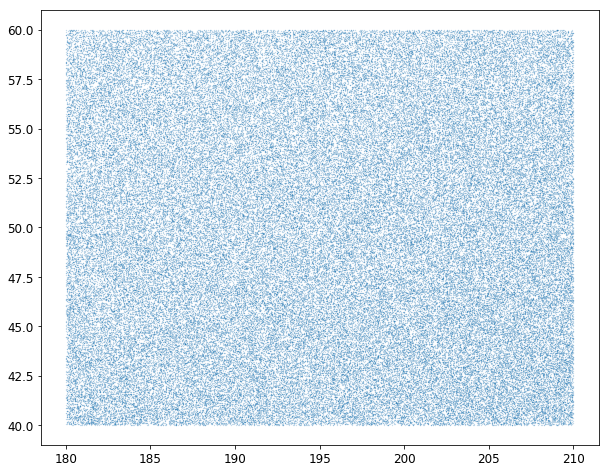

0.527190881619
0.526557660719
0.522049880252
0.5219809156
83257


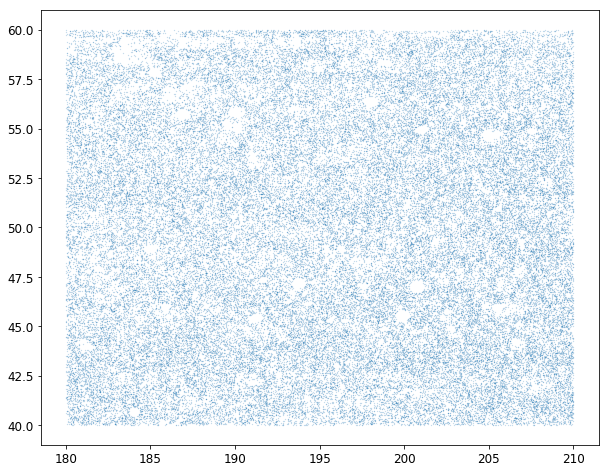

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

mask = (cat['MASKBITS']==0)
print(np.sum(mask)/len(mask))
mask &= cat['TYPE']=='PSF '
print(np.sum(mask)/len(mask))
mask &= cat['FRACFLUX_R']<0.1
print(np.sum(mask)/len(mask))
mask &= np.isfinite(cat['GAIA_PHOT_BP_MEAN_MAG']) & np.isfinite(cat['GAIA_PHOT_RP_MEAN_MAG'])
print(np.sum(mask)/len(mask))
print(np.sum(mask))
cat = cat[mask]

plt.figure(figsize=(10, 8))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.4, alpha=0.5)
plt.show()

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])
    
for band in ['g', 'r', 'z']:
    print(band, cat[band+'mag'].min(), cat[band+'mag'].max())

g 15.9335 21.3797
r 15.8554 19.9237
z 15.079 18.8572


__Supplement with bluest and reddest stars__

In [6]:
extreme = Table.read('/global/cscratch1/sd/rongpu/dr8/misc/dr8_north_gaia_reddest_and_bluest.fits')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    extreme['gmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_G'])
    extreme['rmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_R'])
    extreme['zmag'] = 22.5 - 2.5*np.log10(extreme['FLUX_Z'])
    extreme['w1mag'] = 22.5 - 2.5*np.log10(extreme['FLUX_W1'])
    extreme['w2mag'] = 22.5 - 2.5*np.log10(extreme['FLUX_W2'])

__New polynomial fits__

In [7]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

In [8]:
coeffs_new = {}

mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']>3.1)

for band in ['g', 'r', 'z']:
    x = np.concatenate([(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
    y = np.concatenate([(cat[band+'mag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], (extreme[band+'mag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1]])
    if band=='g' or band=='r':
        poly_order = 12
    else:
        poly_order = 7
    coeffs_new[band] = rlm_fit1d(x, y, t=1, order=poly_order)
    # coeffs_new[band] = np.polyfit(x, y, deg=2)
    print(band)
    print(coeffs_new[band])

g
[ -1.29989582e-01   3.12039397e-01   5.98948269e-01   3.12588249e-01
  -1.94015922e+00   1.10116704e+00   2.07413047e+00  -3.39303064e+00
   2.18572912e+00  -7.67467623e-01   1.54230065e-01  -1.67007725e-02
   7.57372028e-04]
r
[  9.01464643e-02  -2.46371115e-01   9.49630248e-03  -1.18713879e-01
   4.13110739e-01  -1.83218330e-01  -6.01548625e-01   9.80253847e-01
  -6.61380995e-01   2.42639525e-01  -5.05867727e-02   5.64624579e-03
  -2.62578873e-04]
z
[ 0.48620491 -1.02787047  0.12209845  0.30001292 -0.37706626  0.16960906
 -0.03316791  0.00238676]


In [9]:
np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [10]:
coeffs_new

{'g': array([-0.1299895823, 0.3120393968, 0.5989482686, 0.3125882487,
        -1.9401592247, 1.1011670449, 2.0741304659, -3.3930306403,
        2.1857291197, -0.7674676232, 0.1542300648, -0.0167007725,
        0.0007573720]),
 'r': array([0.0901464643, -0.2463711147, 0.0094963025, -0.1187138789,
        0.4131107392, -0.1832183301, -0.6015486252, 0.9802538471,
        -0.6613809948, 0.2426395251, -0.0505867727, 0.0056462458,
        -0.0002625789]),
 'z': array([0.4862049092, -1.0278704657, 0.1220984456, 0.3000129189,
        -0.3770662617, 0.1696090596, -0.0331679127, 0.0023867628])}

In [11]:
coeffs_new = dict(
    g = [-0.1299895823, 0.3120393968, 0.5989482686, 0.3125882487,
        -1.9401592247, 1.1011670449, 2.0741304659, -3.3930306403,
        2.1857291197, -0.7674676232, 0.1542300648, -0.0167007725,
        0.0007573720],
    r = [0.0901464643, -0.2463711147, 0.0094963025, -0.1187138789,
        0.4131107392, -0.1832183301, -0.6015486252, 0.9802538471,
        -0.6613809948, 0.2426395251, -0.0505867727, 0.0056462458,
        -0.0002625789],
    z = [0.4862049092, -1.0278704657, 0.1220984456, 0.3000129189,
        -0.3770662617, 0.1696090596, -0.0331679127, 0.0023867628])

In [12]:
gaia_plot = Table()
gaia_plot['BP_RP'] = np.linspace(-1, 6.2, 200)
bands = ['g', 'r', 'z']
for i, b in enumerate(bands):
    mag = np.zeros(len(gaia_plot))
    for order, c in enumerate(coeffs_new[b]):
        mag += c * gaia_plot['BP_RP']**order
    gaia_plot['ls_'+b] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(cat['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])**order
    cat[b+'mag_predict'] = mag
    
for i, b in enumerate(bands):
    mag = np.copy(extreme['GAIA_PHOT_G_MEAN_MAG'])
    for order, c in enumerate(coeffs_new[b]):
        mag += c * (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])**order
    extreme[b+'mag_predict'] = mag

In [13]:
bprp_min, bprp_max = -0.6, 4.1

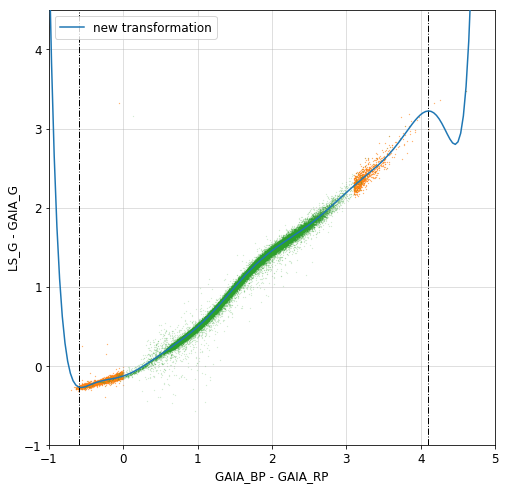

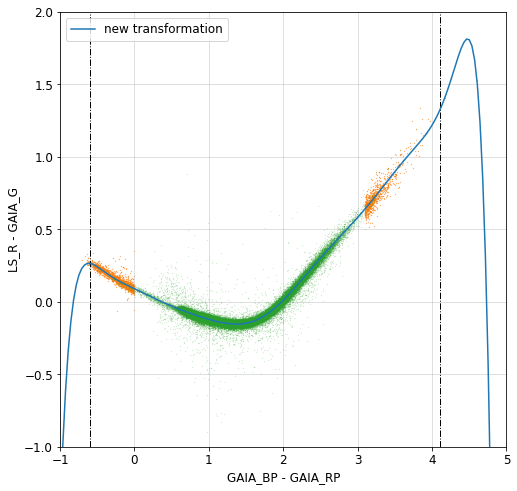

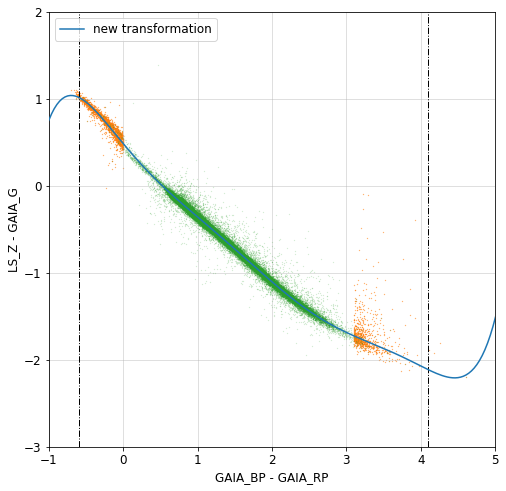

In [30]:
mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']>3.1)

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme['gmag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_g']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_G - GAIA_G')
plt.axis([-1., 5., -1, 4.5])
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/bassmzls_g.png')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme['rmag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_r']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_R - GAIA_G')
plt.axis([-1., 5., -1, 2])
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/bassmzls_r.png')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], 'C2.', ms=0.3, alpha=0.5, zorder=2, c='C2', label='_nolegend_')
plt.plot((extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1], (extreme['zmag']-extreme['GAIA_PHOT_G_MEAN_MAG'])[mask1], '.', ms=0.5, zorder=1, c='C1', label='_nolegend_')
plt.plot((gaia_plot['BP_RP']), (gaia_plot['ls_z']), '-', label='new transformation', zorder=3, c='C0')
plt.axvline(bprp_min, lw=1, ls='-.', color='k')
plt.axvline(bprp_max, lw=1, ls='-.', color='k')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('LS_Z - GAIA_G')
plt.axis([-1., 5., -3, 2.])
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.savefig('plots/bassmzls_z.png')
plt.show()

In [21]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))

def binned_median(x, y, nbins=50):
    vmin, vmax = np.percentile(x, [0.1, 99.9])
    bins = np.linspace(vmin, vmax, nbins)
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

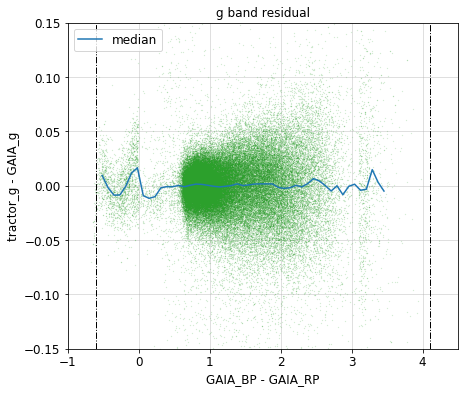

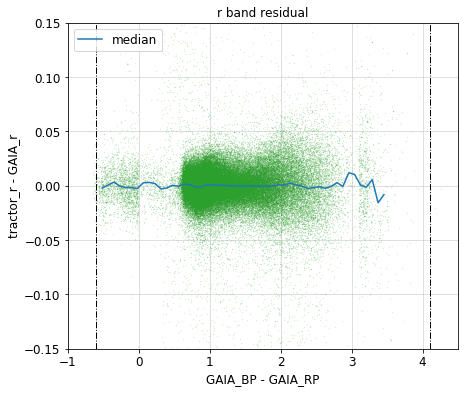

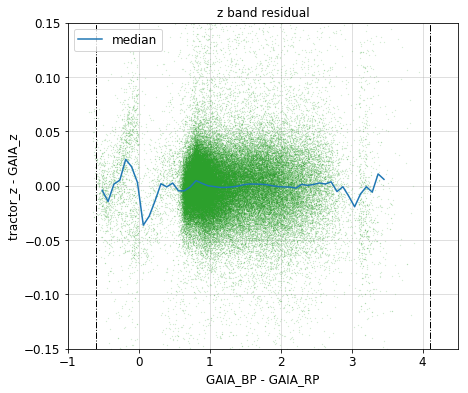

In [31]:
mask = np.ones(len(cat), dtype=bool)
mask1 = (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']<0) 
mask1 |= (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG']>3.1)

for band in ['g', 'r', 'z']:
    x = np.concatenate([(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (extreme['GAIA_PHOT_BP_MEAN_MAG']-extreme['GAIA_PHOT_RP_MEAN_MAG'])[mask1]])
    y_tractor = np.concatenate([(cat[band+'mag'])[mask], (extreme[band+'mag'])[mask1]])
    y_predict = np.concatenate([(cat[band+'mag_predict'])[mask], (extreme[band+'mag_predict'])[mask1]])
    
    bin_center, bin_edges, bin_median, bin_error = binned_median(x, y_tractor-y_predict)
    
    plt.figure(figsize=(7, 6))
    plt.plot(x, y_tractor-y_predict, 'C2.', ms=0.3, alpha=0.5, zorder=2)
    plt.plot(bin_center, bin_median, label='median')
    plt.axvline(bprp_min, lw=1, ls='-.', color='k')
    plt.axvline(bprp_max, lw=1, ls='-.', color='k')
    plt.xlabel('GAIA_BP - GAIA_RP')
    plt.ylabel('tractor_{0} - GAIA_{0}'.format(band))
    plt.title('{} band residual'.format(band))
    plt.axis([-1., 4.5, -0.15, 0.15])
    plt.grid(alpha=0.5)
    plt.legend(markerscale=10, loc='upper left')
    plt.savefig('plots/bassmzls_{}_residual.png'.format(band))
    plt.show()